<a href="https://colab.research.google.com/github/SNMHZ/finedust_predict/blob/master/%EB%AF%B8%EC%84%B8%EB%A8%BC%EC%A7%80_0130.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 / 데이터 로드

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
import matplotlib.pyplot as plt

In [119]:
import tensorflow as tf

In [4]:
#2003년도부터 2017년도까지 미세먼지 데이터 로딩
DUST_DF_DICT={}
for i in range(15):
  DUST_DF_DICT['DUST_%d'%(i+2003)]=pd.read_csv('https://github.com/SNMHZ/finedust_predict/raw/master/dataset/%d.csv'%(i+2003), encoding='EUC_KR')

# 금일 작업


## 아웃라이어 제거 전 모든 과정 쭉

In [60]:
#2017년 데이터에서 수창동 데이터만 뽑는 작업
#왜 신암동만 뽑았나? 학교랑 제일 가까운 동네임
dust2017=DUST_DF_DICT['DUST_2017'].copy()
shinamdong=dust2017.loc[dust2017['측정소명'].where(dust2017['측정소명']=='신암동').dropna().index]
shinamdong

,측정소명,년,월,일,시,SO2,PM10,PM25,O3,NO2,CO
6,신암동,2017,1,1,1,0.003,50,30,0.002,0.037,0.9
17,신암동,2017,1,1,2,0.003,46,31,0.002,0.034,0.8
28,신암동,2017,1,1,3,0.002,40,29,0.002,0.031,0.7
39,신암동,2017,1,1,4,0.002,40,27,0.002,0.030,0.8
50,신암동,2017,1,1,5,0.004,37,29,0.002,0.029,0.9
...,...,...,...,...,...,...,...,...,...,...,...
96420,신암동,2017,12,31,20,0.004,62,20,0.029,0.017,0.4
96433,신암동,2017,12,31,21,0.004,55,22,0.030,0.016,0.4
96446,신암동,2017,12,31,22,0.005,54,16,0.023,0.023,0.4
96459,신암동,2017,12,31,23,0.005,56,19,0.022,0.024,0.4


In [61]:
#신암동 1시간 후 데이터 밀어서 목표 데이터셋 생성
shinamdong['PM10_res']=shinamdong['PM10'].shift(-1)
shinamdong['PM25_res']=shinamdong['PM25'].shift(-1)
shinamdong

,측정소명,년,월,일,시,SO2,PM10,PM25,O3,NO2,CO,PM10_res,PM25_res
6,신암동,2017,1,1,1,0.003,50,30,0.002,0.037,0.9,46.0,31.0
17,신암동,2017,1,1,2,0.003,46,31,0.002,0.034,0.8,40.0,29.0
28,신암동,2017,1,1,3,0.002,40,29,0.002,0.031,0.7,40.0,27.0
39,신암동,2017,1,1,4,0.002,40,27,0.002,0.030,0.8,37.0,29.0
50,신암동,2017,1,1,5,0.004,37,29,0.002,0.029,0.9,45.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96420,신암동,2017,12,31,20,0.004,62,20,0.029,0.017,0.4,55.0,22.0
96433,신암동,2017,12,31,21,0.004,55,22,0.030,0.016,0.4,54.0,16.0
96446,신암동,2017,12,31,22,0.005,54,16,0.023,0.023,0.4,56.0,19.0
96459,신암동,2017,12,31,23,0.005,56,19,0.022,0.024,0.4,50.0,17.0


In [62]:
#한칸 밀었으니 마지막줄 없애버리기 
#-> 데이터셋 기본 전처리(1시간 후 PM10 갖다 붙이기) 완료.
shinamdong=shinamdong[:-1]
shinamdong

,측정소명,년,월,일,시,SO2,PM10,PM25,O3,NO2,CO,PM10_res,PM25_res
6,신암동,2017,1,1,1,0.003,50,30,0.002,0.037,0.9,46.0,31.0
17,신암동,2017,1,1,2,0.003,46,31,0.002,0.034,0.8,40.0,29.0
28,신암동,2017,1,1,3,0.002,40,29,0.002,0.031,0.7,40.0,27.0
39,신암동,2017,1,1,4,0.002,40,27,0.002,0.030,0.8,37.0,29.0
50,신암동,2017,1,1,5,0.004,37,29,0.002,0.029,0.9,45.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96407,신암동,2017,12,31,19,0.004,66,18,0.034,0.014,0.4,62.0,20.0
96420,신암동,2017,12,31,20,0.004,62,20,0.029,0.017,0.4,55.0,22.0
96433,신암동,2017,12,31,21,0.004,55,22,0.030,0.016,0.4,54.0,16.0
96446,신암동,2017,12,31,22,0.005,54,16,0.023,0.023,0.4,56.0,19.0


In [67]:
#단순 선형회귀로 먼저 테스트 해보기
#학습 데이터셋, 결과 데이터셋 만들기
#학습용(현재 PM10), 결과(1시간 후 PM10) 
X = shinamdong[['PM10']].copy()
y = shinamdong[['PM10_res']].copy()

In [70]:
#(현재 PM10), (1시간 후 PM10) 두 가지로 단순 선형회귀(모델 자체 정규화 이용)
#이후 점수 확인. -> 결과 개판
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.24720023262267699

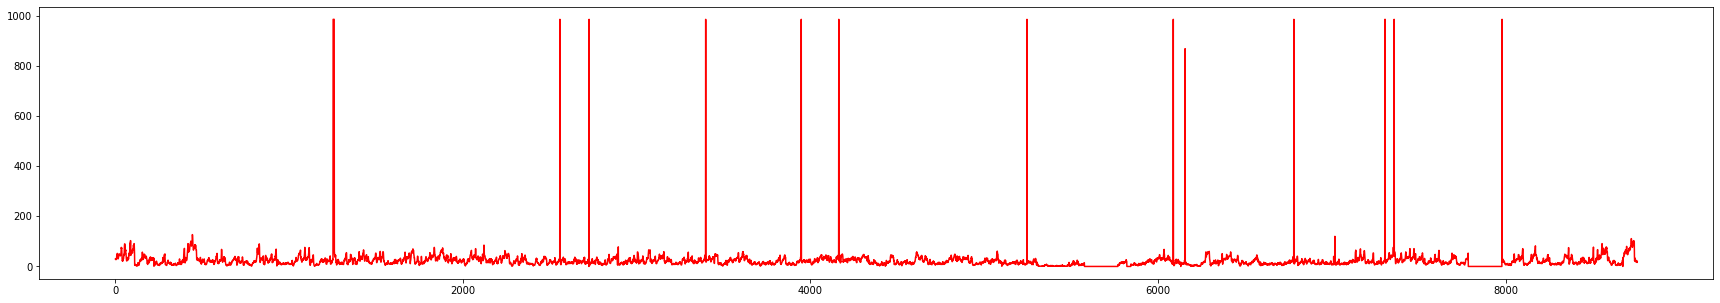

In [59]:
plt.figure(figsize=(30, 5))
plt.plot(shinamdong[['PM25']].reset_index().index, shinamdong[['PM25']].reset_index()['PM25'], color='red')
#plt.plot(X.reset_index().index, model.predict(X), color='blue',)

plt.show()

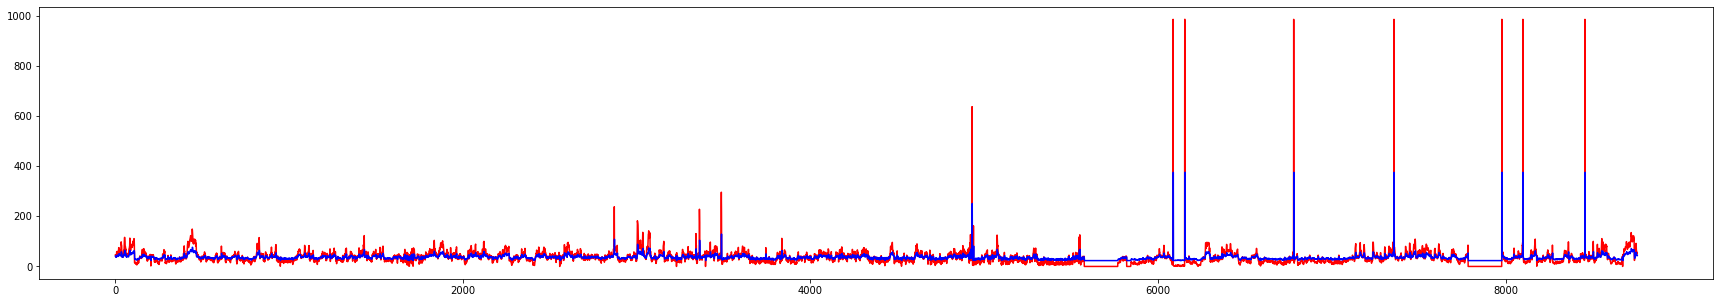

In [10]:
plt.figure(figsize=(30, 5))
plt.plot(X.reset_index().index, y.reset_index()['PM10_res'], color='red')
plt.plot(X.reset_index().index, model.predict(X), color='blue',)

plt.show()

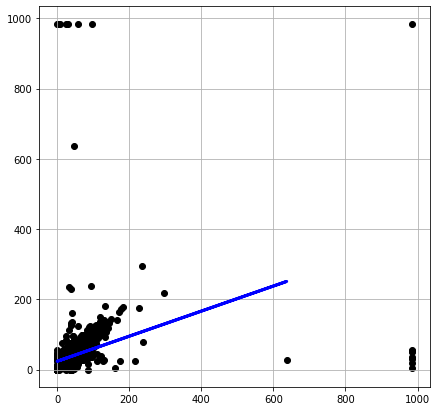

In [11]:
#어떻게 회귀가 되었는지 그래프를 그려보았다.
#->아웃라이어 제거의 필요성을 느꼈다
plt.figure(figsize=(7, 7))
plt.grid(True)
plt.scatter(shinamdong['PM10'], shinamdong['PM10_res'],  color='black')
plt.plot(X_test, model.predict(X_test), color='blue', linewidth=3)

plt.show()

## 아웃라이어 처리 방법 선택 이유

아웃라이어 처리 방법으로는 winsorize, trim이 대표적이다

우리는 trim방법을 사용했다 왜?

0~30㎛/㎥(좋음)

31~80㎛/㎥(보통)	

81~150㎛/㎥(나쁨)	

151㎛/㎥ 이상(매우나쁨)

이 기준인데 최고 값에서 같은 값이 자주 나타나는 것을 목격할 수 있었다.

기계 오작동으로 인한 잘못된 측정으로 추정되어, trim 기법을 이용하기로 했다.

또한, 매우 나쁨 기준치의 4배 이상씩 되는 수치도 주변에서 모래를 뿌리거나 기계 오작동 등 정상적이지 않은 상황으로 추정하여 같이 trim하기로 결정하였다.

그래서 어디를 기준으로 자를 것인치 결정하기로 했다.

### 처리 후 산포도 그림들

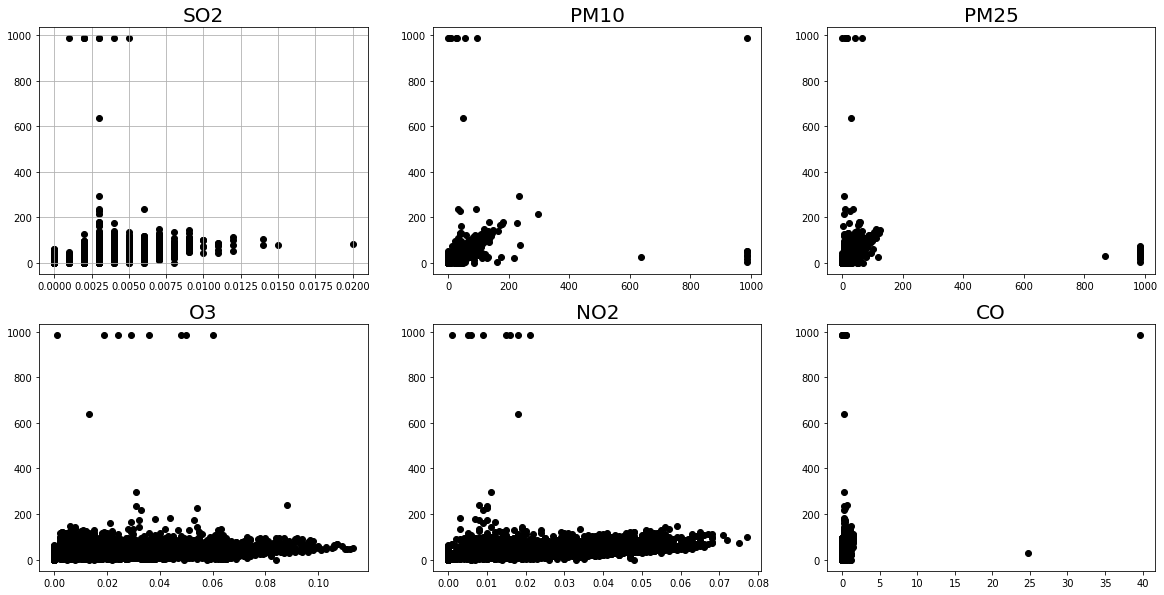

In [51]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('SO2', size = 20,)
plt.grid(True)
plt.scatter(shinamdong['SO2'], shinamdong['PM10_res'],  color='black')

plt.subplot(232)
plt.title('PM10', size = 20,)
plt.scatter(shinamdong['PM10'], shinamdong['PM10_res'],  color='black')

plt.subplot(233)
plt.title('PM25', size = 20,)
plt.scatter(shinamdong['PM25'], shinamdong['PM10_res'],  color='black')

plt.subplot(234)
plt.title('O3', size = 20,)
plt.scatter(shinamdong['O3'], shinamdong['PM10_res'],  color='black')

plt.subplot(235)
plt.title('NO2', size = 20,)
plt.scatter(shinamdong['NO2'], shinamdong['PM10_res'],  color='black')

plt.subplot(236)
plt.title('CO', size = 20,)
plt.scatter(shinamdong['CO'], shinamdong['PM10_res'],  color='black')
plt.show()

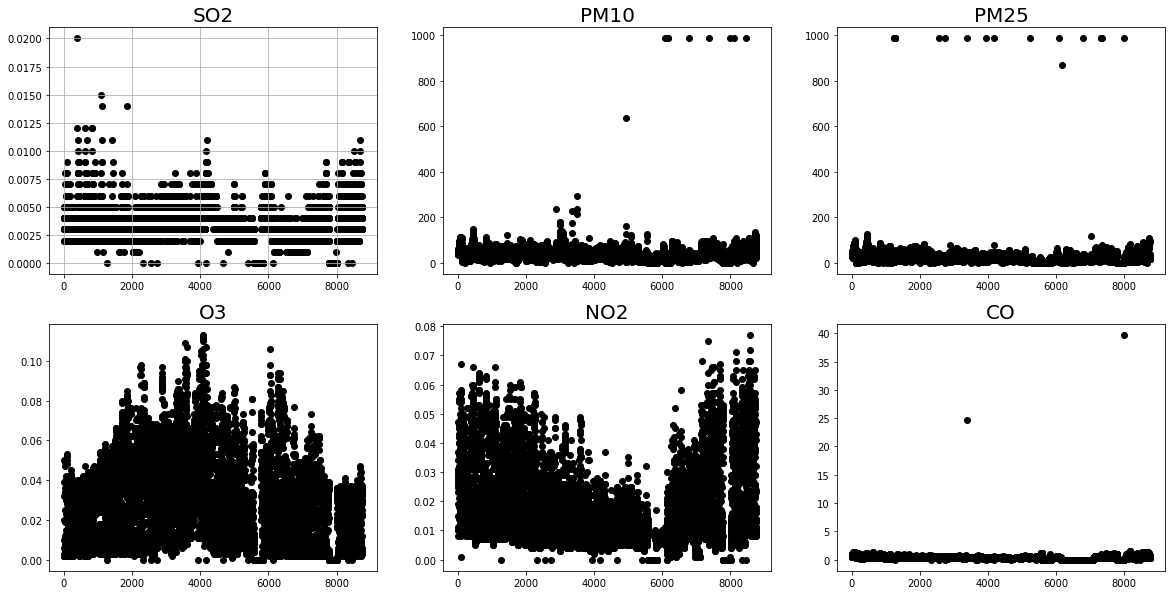

In [54]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('SO2', size = 20,)
plt.grid(True)
plt.scatter(shinamdong.reset_index().index, shinamdong['SO2'],  color='black')

plt.subplot(232)
plt.title('PM10', size = 20,)
plt.scatter(shinamdong.reset_index().index, shinamdong['PM10'],  color='black')

plt.subplot(233)
plt.title('PM25', size = 20,)
plt.scatter(shinamdong.reset_index().index, shinamdong['PM25'],  color='black')

plt.subplot(234)
plt.title('O3', size = 20,)
plt.scatter(shinamdong.reset_index().index, shinamdong['O3'],  color='black')

plt.subplot(235)
plt.title('NO2', size = 20,)
plt.scatter(shinamdong.reset_index().index, shinamdong['NO2'],  color='black')

plt.subplot(236)
plt.title('CO', size = 20,)
plt.scatter(shinamdong.reset_index().index, shinamdong['CO'],  color='black')
plt.show()

In [91]:
#PM10 400이상 & 0 날리기
shinamdong_drop = shinamdong[ (shinamdong['PM10']<400) & (shinamdong['PM10_res']<400) ]
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['PM10']!=0) & (shinamdong_drop['PM10_res']!=0) ]
#PM10 400이상 & 0 날리기
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['PM25']<400) & (shinamdong_drop['PM25_res']<400) ]
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['PM25']!=0) & (shinamdong_drop['PM25_res']!=0) ]

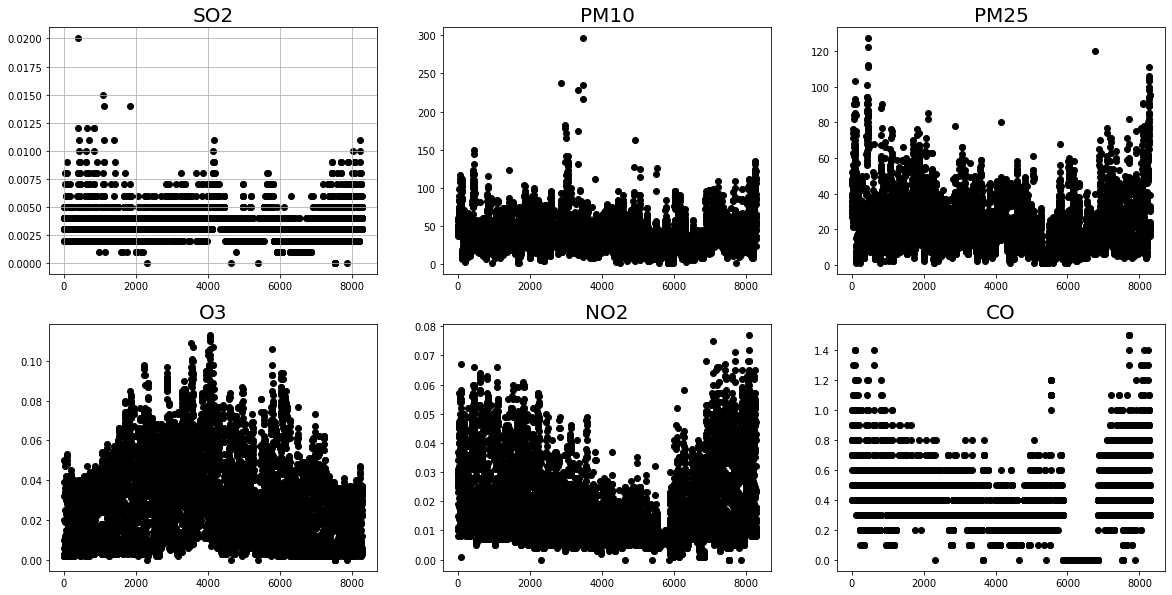

In [92]:
#CO에 이상 있는거 확인하기. 센서 고장으로 추정됨.
fig = plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('SO2', size = 20,)
plt.grid(True)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['SO2'],  color='black')

plt.subplot(232)
plt.title('PM10', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['PM10'],  color='black')

plt.subplot(233)
plt.title('PM25', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['PM25'],  color='black')

plt.subplot(234)
plt.title('O3', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['O3'],  color='black')

plt.subplot(235)
plt.title('NO2', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['NO2'],  color='black')

plt.subplot(236)
plt.title('CO', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['CO'],  color='black')
plt.show()

In [93]:
#PM10 400이상 & 0 날리기
shinamdong_drop = shinamdong[ (shinamdong['PM10']<400) & (shinamdong['PM10_res']<400) ]
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['PM10']!=0) & (shinamdong_drop['PM10_res']!=0) ]
#PM10 400이상 & 0 날리기
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['PM25']<400) & (shinamdong_drop['PM25_res']<400) ]
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['PM25']!=0) & (shinamdong_drop['PM25_res']!=0) ]
#기타 대기 인자 0 날리기
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['SO2']!=0) ]
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['O3']!=0) ]
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['NO2']!=0) ]
shinamdong_drop = shinamdong_drop[ (shinamdong_drop['CO']!=0) ]

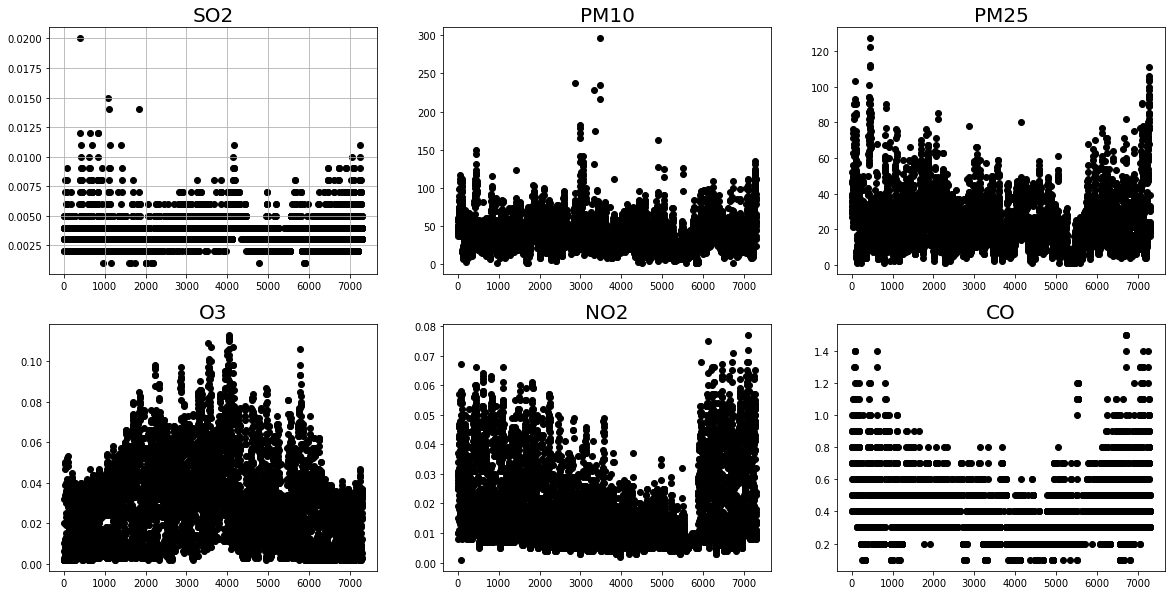

In [87]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('SO2', size = 20,)
plt.grid(True)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['SO2'],  color='black')

plt.subplot(232)
plt.title('PM10', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['PM10'],  color='black')

plt.subplot(233)
plt.title('PM25', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['PM25'],  color='black')

plt.subplot(234)
plt.title('O3', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['O3'],  color='black')

plt.subplot(235)
plt.title('NO2', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['NO2'],  color='black')

plt.subplot(236)
plt.title('CO', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['CO'],  color='black')
plt.show()

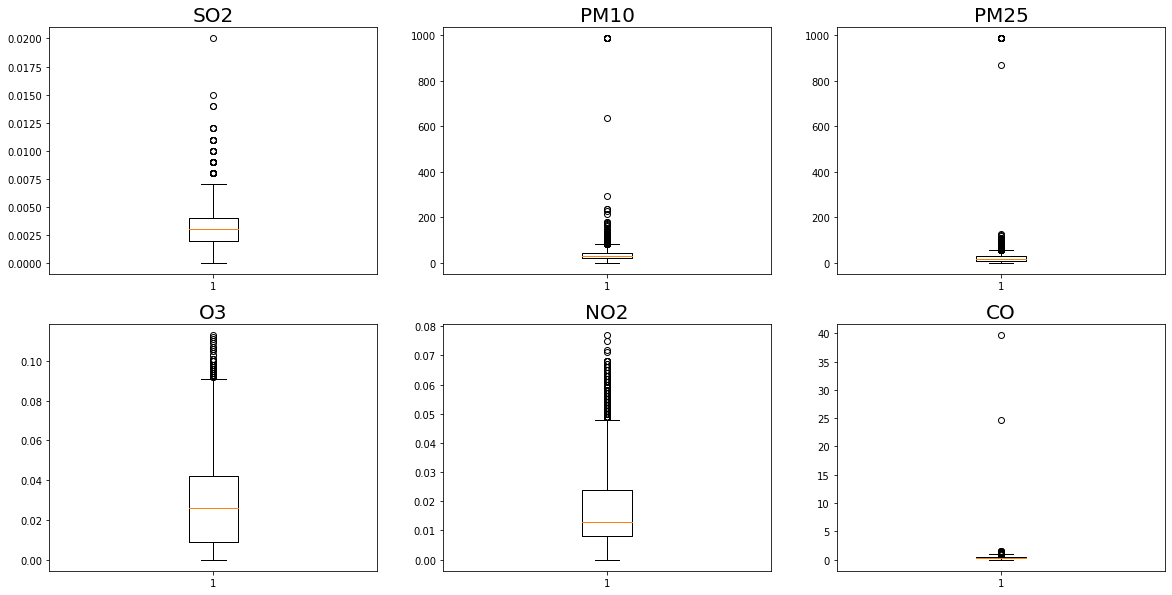

In [47]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('SO2', size = 20,)
plt.boxplot(shinamdong['SO2'])

plt.subplot(232)
plt.title('PM10', size = 20,)
plt.boxplot(shinamdong['PM10'])

plt.subplot(233)
plt.title('PM25', size = 20,)
plt.boxplot(shinamdong['PM25'])

plt.subplot(234)
plt.title('O3', size = 20,)
plt.boxplot(shinamdong['O3'])

plt.subplot(235)
plt.title('NO2', size = 20,)
plt.boxplot(shinamdong['NO2'])

plt.subplot(236)
plt.title('CO', size = 20,)
plt.boxplot(shinamdong['CO'])
plt.show()

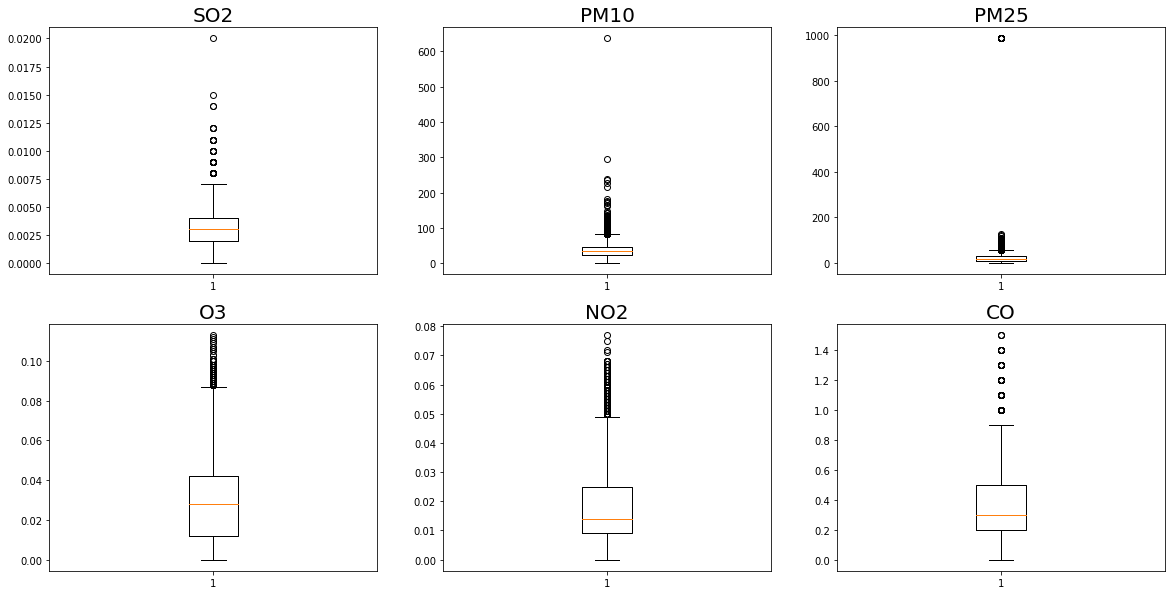

In [50]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('SO2', size = 20,)
plt.boxplot(shinamdong_drop['SO2'])

plt.subplot(232)
plt.title('PM10', size = 20,)
plt.boxplot(shinamdong_drop['PM10'])

plt.subplot(233)
plt.title('PM25', size = 20,)
plt.boxplot(shinamdong_drop['PM25'])

plt.subplot(234)
plt.title('O3', size = 20,)
plt.boxplot(shinamdong_drop['O3'])

plt.subplot(235)
plt.title('NO2', size = 20,)
plt.boxplot(shinamdong_drop['NO2'])

plt.subplot(236)
plt.title('CO', size = 20,)
plt.boxplot(shinamdong_drop['CO'])
plt.show()

### 처리 후 선형회귀

In [99]:
shinamdong_drop.head(3)

,측정소명,년,월,일,시,SO2,PM10,PM25,O3,NO2,CO,PM10_res,PM25_res
6,신암동,2017,1,1,1,0.003,50,30,0.002,0.037,0.9,46.0,31.0
17,신암동,2017,1,1,2,0.003,46,31,0.002,0.034,0.8,40.0,29.0
28,신암동,2017,1,1,3,0.002,40,29,0.002,0.031,0.7,40.0,27.0


In [98]:
len(shinamdong_drop)

7310

In [100]:
#단순 선형회귀로 먼저 테스트 해보기
#학습 데이터셋, 결과 데이터셋 만들기
#학습용(현재 PM10), 결과(1시간 후 PM10) 
X = shinamdong_drop[['PM10']].copy()
y = shinamdong_drop[['PM10_res']].copy()

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8044454567825785

In [111]:
model.predict([[1], [max(shinamdong_drop['PM10'])]])

array([[  6.71077751],
       [256.73413915]])

In [158]:
shinamdong_drop[shinamdong_drop['PM10_res']>=200]

,측정소명,년,월,일,시,SO2,PM10,PM25,O3,NO2,CO,PM10_res,PM25_res
31587,신암동,2017,4,30,16,0.006,93,35,0.088,0.008,0.6,238.0,33.0
36977,신암동,2017,5,21,2,0.003,40,25,0.054,0.010,0.4,228.0,22.0
38352,신암동,2017,5,26,7,0.003,34,11,0.031,0.010,0.3,235.0,7.0
38363,신암동,2017,5,26,8,0.003,235,7,0.031,0.011,0.3,296.0,6.0
38374,신암동,2017,5,26,9,0.003,296,6,0.033,0.009,0.3,217.0,6.0


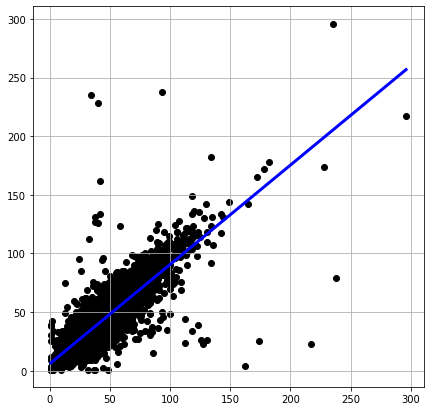

In [116]:
plt.figure(figsize=(7, 7))
plt.grid(True)
plt.scatter(shinamdong_drop['PM10'], shinamdong_drop['PM10_res'],  color='black')
linex = [ [min(shinamdong_drop['PM10'])], [max(shinamdong_drop['PM10'])] ]
plt.plot(linex, model.predict(linex), color='blue', linewidth=3)

plt.show()

In [ ]:
plt.figure(figsize=(7, 7))
plt.grid(True)

plt.scatter(shinamdong_drop['PM10'], shinamdong_drop['PM10_res'],  color='black')
linex = [ [min(shinamdong_drop['PM10'])], [max(shinamdong_drop['PM10'])] ]
plt.plot(linex, model.predict(linex), color='blue', linewidth=3)

plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('SO2', size = 20,)
plt.grid(True)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['SO2'],  color='black')

plt.subplot(232)
plt.title('PM10', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['PM10'],  color='black')

plt.subplot(233)
plt.title('PM25', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['PM25'],  color='black')

plt.subplot(234)
plt.title('O3', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['O3'],  color='black')

plt.subplot(235)
plt.title('NO2', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['NO2'],  color='black')

plt.subplot(236)
plt.title('CO', size = 20,)
plt.scatter(shinamdong_drop.reset_index().index, shinamdong_drop['CO'],  color='black')
plt.show()

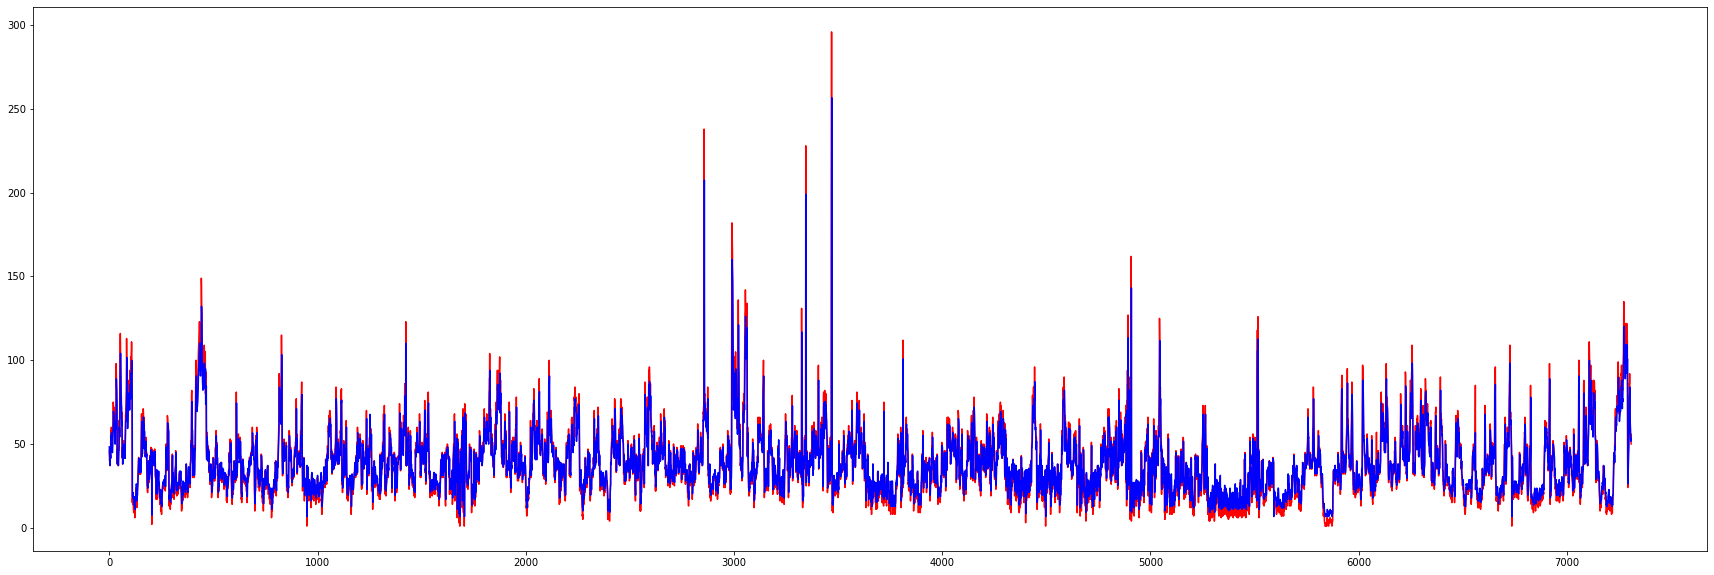

In [114]:
plt.figure(figsize=(30, 10))
plt.plot(X.reset_index().index, y.reset_index()['PM10_res'], color='red')
plt.plot(X.reset_index().index, model.predict(X), color='blue',)

plt.show()

### 처리 후 딥러닝

In [139]:
#단순 선형회귀로 먼저 테스트 해보기
#학습 데이터셋, 결과 데이터셋 만들기
#학습용(현재 PM10), 결과(1시간 후 PM10) 
X = shinamdong_drop[['PM10']].copy()
y = shinamdong_drop[['PM10_res']].copy()

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

#### Z스코어 정규화

In [141]:
#z스코어 정규화
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train -= X_mean
X_train /= X_std
X_test -= X_mean
X_test /= X_std

y_mean = y_train.mean(axis=0)
y_std = y_train.std(axis=0)
y_train -= y_mean
y_train /= y_std
y_test -= y_mean
y_test /= y_std

print(X_train, y_train)

           PM10
79085  1.382910
43555 -0.215660
54324  0.160474
2305   0.301525
42994 -0.591794
...         ...
33666  1.712028
19069 -0.497760
45150  1.429927
24888  1.523961
32225 -0.732844

[5848 rows x 1 columns]        PM10_res
79085  0.396753
43555 -0.073725
54324  5.807258
2305   0.161514
42994 -1.249922
...         ...
33666  1.337711
19069 -0.261917
45150  1.337711
24888  1.714093
32225 -0.779444

[5848 rows x 1 columns]


In [142]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(units=1, activation='relu', input_shape=(1,)),
                             tf.keras.layers.Dense(units=8, activation='relu'),
                             tf.keras.layers.Dense(units=8, activation='relu'),
                             tf.keras.layers.Dense(units=1),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [143]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')

In [144]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')])

Epoch 1/100
147/147 [==============================] - 1s 2ms/step - loss: 0.8774 - val_loss: 0.6743
Epoch 2/100
147/147 [==============================] - 0s 1ms/step - loss: 0.5270 - val_loss: 0.3182
Epoch 3/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2757 - val_loss: 0.2903
Epoch 4/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2973 - val_loss: 0.2885
Epoch 5/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2771 - val_loss: 0.2813
Epoch 6/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2707 - val_loss: 0.2828
Epoch 7/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2636 - val_loss: 0.2848
Epoch 8/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2511 - val_loss: 0.2817
Epoch 9/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2253 - val_loss: 0.2811
Epoch 10/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2747 - val_lo

In [147]:
line_x = np.arange(min(X_test['PM10']), max(X_test['PM10']), 0.01)#.reshape(1, -1)
line_y=model.predict(line_x)

In [155]:
len(shinamdong[shinamdong['PM10']>=120])

8716

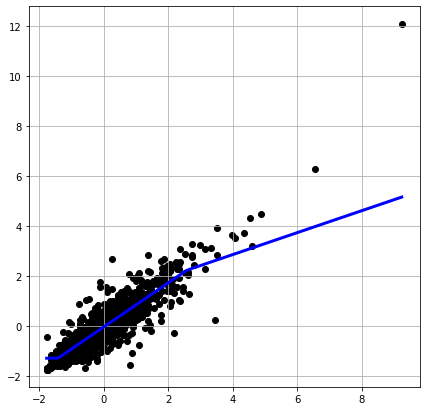

In [152]:
plt.figure(figsize=(7, 7))
plt.grid(True)
plt.scatter(X_test['PM10'], y_test['PM10_res'],  color='black')
#linex = [ [min(shinamdong_drop['PM10'])], [max(shinamdong_drop['PM10'])] ]
#line_x = np.arange(min(X_test['PM10']), max(X_test['PM10']), 0.01)
plt.plot(line_x, line_y, color='blue', linewidth=3)

plt.show()

In [150]:
y_pred = model.predict(X_test)
u = ((y_test - y_pred) ** 2).sum()
v = ((y_test - y_test.mean()) ** 2).sum()
R = 1 - (u / v)
R

PM10_res    0.776106
dtype: float64

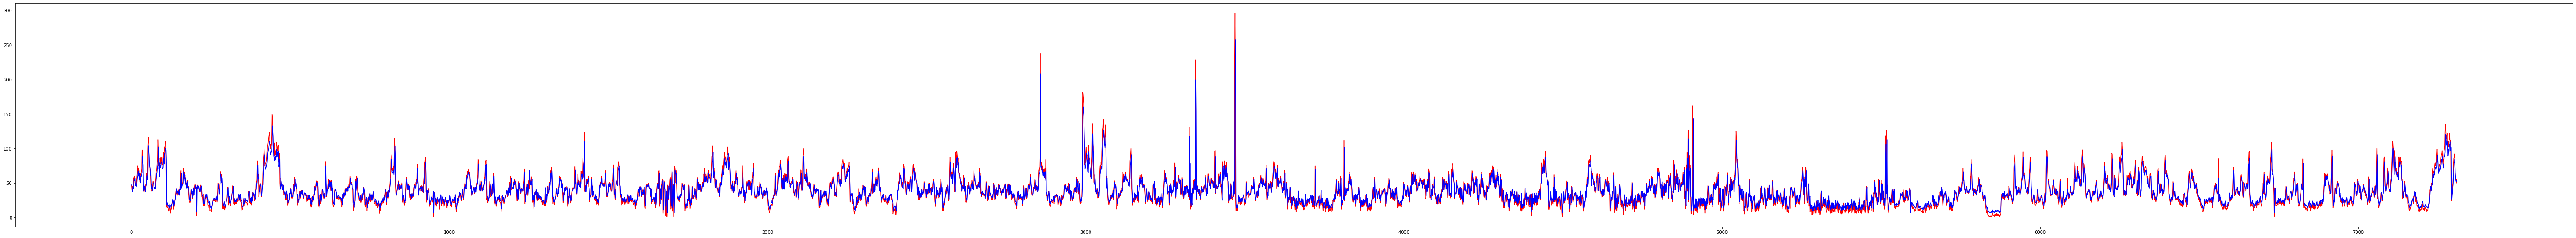

In [129]:
plt.figure(figsize=(100, 9))
plt.plot(y.reset_index().index, y.reset_index()['PM10_res'], color='red')
plt.plot(y.reset_index().index, model.predict(X), color='blue',)

plt.show()

In [156]:
deepx_nor = X.copy()
deepx_nor -= X_mean
deepx_nor /= X_std
deepy_nor = y.copy()
deepy_nor -= y_mean
deepy_nor /= y_std

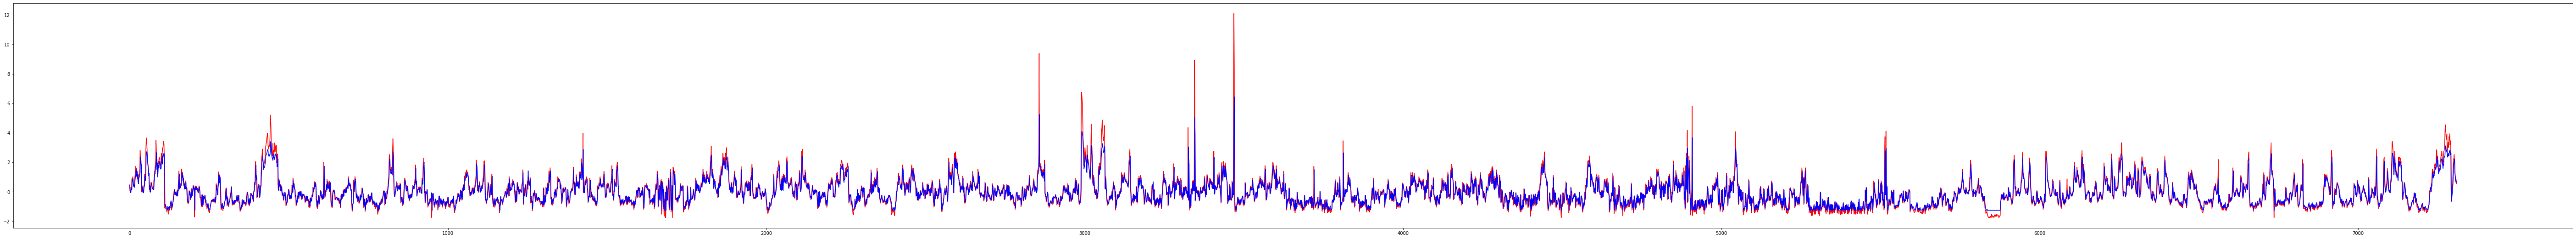

In [157]:
plt.figure(figsize=(100, 9))
plt.plot(y.reset_index().index, deepy_nor.reset_index()['PM10_res'], color='red')
plt.plot(y.reset_index().index, model.predict(deepx_nor), color='blue',)

plt.show()

In [ ]:
plt.figure(figsize=(100, 9))
plt.plot(y.reset_index().index, y.reset_index()['PM10_res'], color='red')
plt.plot(y.reset_index().index, model.predict(X), color='blue',)

plt.show()

#### MinMax 정규화

In [266]:
#단순 선형회귀로 먼저 테스트 해보기
#학습 데이터셋, 결과 데이터셋 만들기
#학습용(현재 PM10), 결과(1시간 후 PM10) 
X = shinamdong_drop[['PM10']].copy()
y = shinamdong_drop[['PM10_res']].copy()

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [268]:
#minmax 정규화
min_X, max_X = min(X['PM10']), max(X['PM10'])
range_X = max_X - min_X

X_train -= min_X
X_train /= range_X
X_test -= min_X
X_test /= range_X

min_Y, max_Y = min(y['PM10_res']), max(y['PM10_res'])
range_Y = max_Y - min_Y
y_train -= min_Y
y_train /= range_Y
y_test -= min_Y
y_test /= range_Y

print(X_train, y_train)

           PM10
79085  0.227119
43555  0.111864
54324  0.138983
2305   0.149153
42994  0.084746
...         ...
33666  0.250847
19069  0.091525
45150  0.230508
24888  0.237288
32225  0.074576

[5848 rows x 1 columns]        PM10_res
79085  0.155932
43555  0.122034
54324  0.545763
2305   0.138983
42994  0.037288
...         ...
33666  0.223729
19069  0.108475
45150  0.223729
24888  0.250847
32225  0.071186

[5848 rows x 1 columns]


In [269]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(units=1, activation='relu', input_shape=(1,)),
                             tf.keras.layers.Dense(units=8, activation='relu'),
                             tf.keras.layers.Dense(units=8, activation='relu'),
                             tf.keras.layers.Dense(units=1),
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_52 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_53 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 9         
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [270]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')

In [271]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')])

Epoch 1/100
147/147 [==============================] - 1s 2ms/step - loss: 0.0077 - val_loss: 0.0039
Epoch 2/100
147/147 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 3/100
147/147 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 4/100
147/147 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/100
147/147 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 6/100
147/147 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/100
147/147 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/100
147/147 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 9/100
147/147 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/100
147/147 [==============================] - 0s 1ms/step - loss: 0.0014 - val_lo

In [272]:
line_x = np.arange(min(X_test['PM10']), max(X_test['PM10']), 0.01)#.reshape(1, -1)
line_y=model.predict(line_x)

In [273]:
X_minmax = X.copy()
y_minmax = y.copy()

In [274]:
X_minmax -= min_X
X_minmax /= range_X
y_minmax -= min_Y
y_minmax /=  range_Y

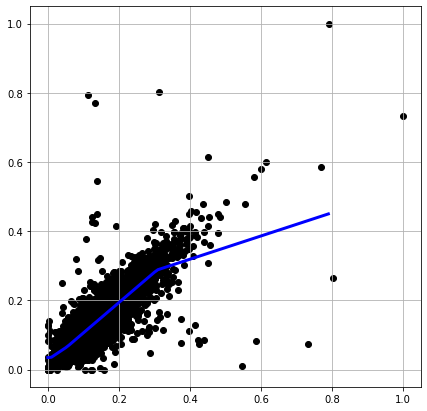

In [275]:
plt.figure(figsize=(7, 7))
plt.grid(True)
plt.scatter(X_minmax['PM10'], y_minmax['PM10_res'],  color='black')
#linex = [ [min(shinamdong_drop['PM10'])], [max(shinamdong_drop['PM10'])] ]
#line_x = np.arange(min(X_test['PM10']), max(X_test['PM10']), 0.01)
plt.plot(line_x, line_y, color='blue', linewidth=3)

plt.show()

In [276]:
y_pred = model.predict(X_test)
u = ((y_test - y_pred) ** 2).sum()
v = ((y_test - y_test.mean()) ** 2).sum()
R = 1 - (u / v)
R

PM10_res    0.764223
dtype: float64

In [277]:
model.predict(y_minmax['PM10_res'])*range_Y+min_Y

array([[45.77636 ],
       [40.518642],
       [40.518642],
       ...,
       [52.78664 ],
       [54.53922 ],
       [49.281498]], dtype=float32)

In [278]:
model.predict(X_minmax['PM10'])

array([[0.16366613],
       [0.15178427],
       [0.1339615 ],
       ...,
       [0.17851841],
       [0.17554793],
       [0.18148887]], dtype=float32)

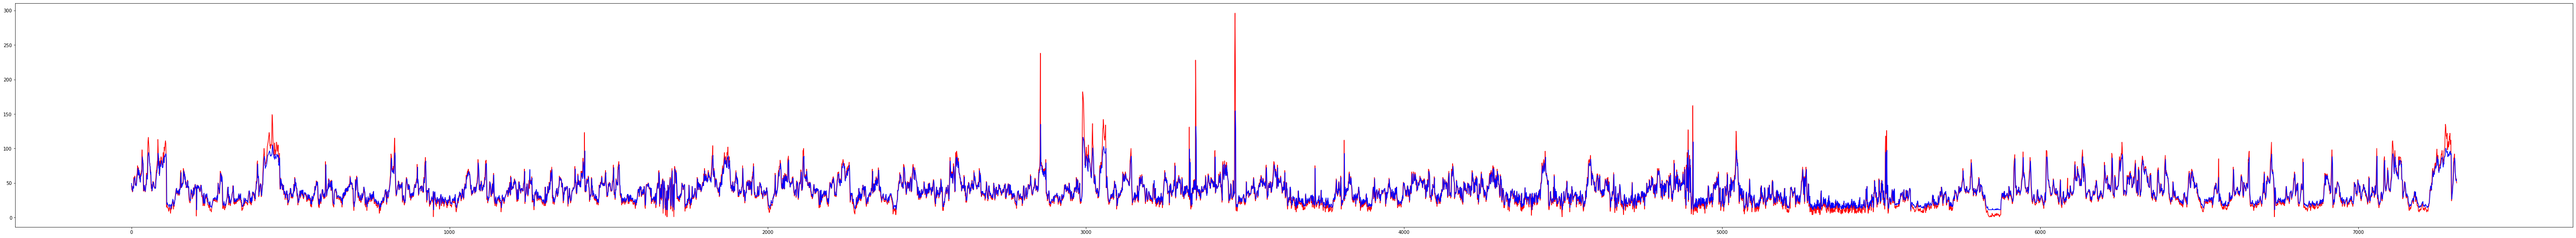

In [279]:
plt.figure(figsize=(100, 9))
plt.plot(y.reset_index().index, y.reset_index()['PM10_res'], color='red')
plt.plot(y.reset_index().index, model.predict(X_minmax['PM10'])*range_Y+min_Y, color='blue',)

plt.show()

## 피쳐 추가 후 딥러닝

In [195]:
shinamdong_drop.head(3)

,측정소명,년,월,일,시,SO2,PM10,PM25,O3,NO2,CO,PM10_res,PM25_res
6,신암동,2017,1,1,1,0.003,50,30,0.002,0.037,0.9,46.0,31.0
17,신암동,2017,1,1,2,0.003,46,31,0.002,0.034,0.8,40.0,29.0
28,신암동,2017,1,1,3,0.002,40,29,0.002,0.031,0.7,40.0,27.0


In [221]:
#단순 선형회귀로 먼저 테스트 해보기
#학습 데이터셋, 결과 데이터셋 만들기
#학습용(현재 PM10), 결과(1시간 후 PM10) 
X = shinamdong_drop[['PM10', 'PM25', 'SO2', 'O3', 'NO2', 'CO']].copy()
y = shinamdong_drop[['PM10_res']].copy()

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [224]:
#minmax 정규화
min_X, max_X = X.min(axis=0), X.max(axis=0)
range_X = max_X - min_X

X_train -= min_X
X_train /= range_X
X_test -= min_X
X_test /= range_X

min_Y, max_Y = y.min(axis=0), y.max(axis=0)
range_Y = max_Y - min_Y
y_train -= min_Y
y_train /= range_Y
y_test -= min_Y
y_test /= range_Y

print(X_train, y_train)

           PM10      PM25       SO2        O3       NO2        CO
79085  0.227119  0.404762  0.157895  0.531532  0.197368  0.285714
43555  0.111864  0.174603  0.105263  0.486486  0.223684  0.071429
54324  0.138983  0.023810  0.105263  0.171171  0.105263  0.071429
2305   0.149153  0.214286  0.105263  0.315315  0.210526  0.214286
42994  0.084746  0.055556  0.105263  0.306306  0.078947  0.000000
...         ...       ...       ...       ...       ...       ...
33666  0.250847  0.230159  0.157895  0.558559  0.171053  0.214286
19069  0.091525  0.134921  0.052632  0.054054  0.421053  0.214286
45150  0.230508  0.333333  0.157895  0.180180  0.144737  0.071429
24888  0.237288  0.380952  0.157895  0.054054  0.631579  0.428571
32225  0.074576  0.071429  0.263158  0.252252  0.157895  0.357143

[5848 rows x 6 columns]        PM10_res
79085  0.155932
43555  0.122034
54324  0.545763
2305   0.138983
42994  0.037288
...         ...
33666  0.223729
19069  0.108475
45150  0.223729
24888  0.250847
32225  

In [208]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(units=6, activation='relu', input_shape=(6,)),
                             tf.keras.layers.Dense(units=8, activation='relu'),
                             tf.keras.layers.Dense(units=8, activation='relu'),
                             tf.keras.layers.Dense(units=8, activation='relu'),
                             tf.keras.layers.Dense(units=1),
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_33 (Dense)             (None, 8)                 56        
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_35 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 9         
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


In [209]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')

In [210]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')])

Epoch 1/100
147/147 [==============================] - 1s 2ms/step - loss: 0.0070 - val_loss: 0.0022
Epoch 2/100
147/147 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 3/100
147/147 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 4/100
147/147 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 5/100
147/147 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 6/100
147/147 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 7/100
147/147 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 8/100
147/147 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 9/100
147/147 [==============================] - 0s 1ms/step - loss: 9.9187e-04 - val_loss: 0.0017
Epoch 10/100
147/147 [==============================] - 0s 2ms/step - loss: 0.0013 - va

In [211]:
y_pred = model.predict(X_test)
u = ((y_test - y_pred) ** 2).sum()
v = ((y_test - y_test.mean()) ** 2).sum()
R = 1 - (u / v)
R

PM10_res    0.742307
dtype: float64

In [226]:
X_minmax = X.copy()
X_minmax -= min_X
X_minmax /=  range_X

In [230]:
model.predict(X_minmax)

array([[0.15899104],
       [0.1516732 ],
       [0.13261543],
       ...,
       [0.1688424 ],
       [0.16118847],
       [0.16766925]], dtype=float32)

In [235]:
range_Y

PM10_res    295.0
dtype: float64

In [239]:
min_Y

PM10_res    1.0
dtype: float64

In [241]:
model.predict(X_minmax)*range_Y.values+min_Y.values

array([[47.90235645],
       [45.74359334],
       [40.12155248],
       ...,
       [50.8085095 ],
       [48.55059816],
       [50.46242921]])

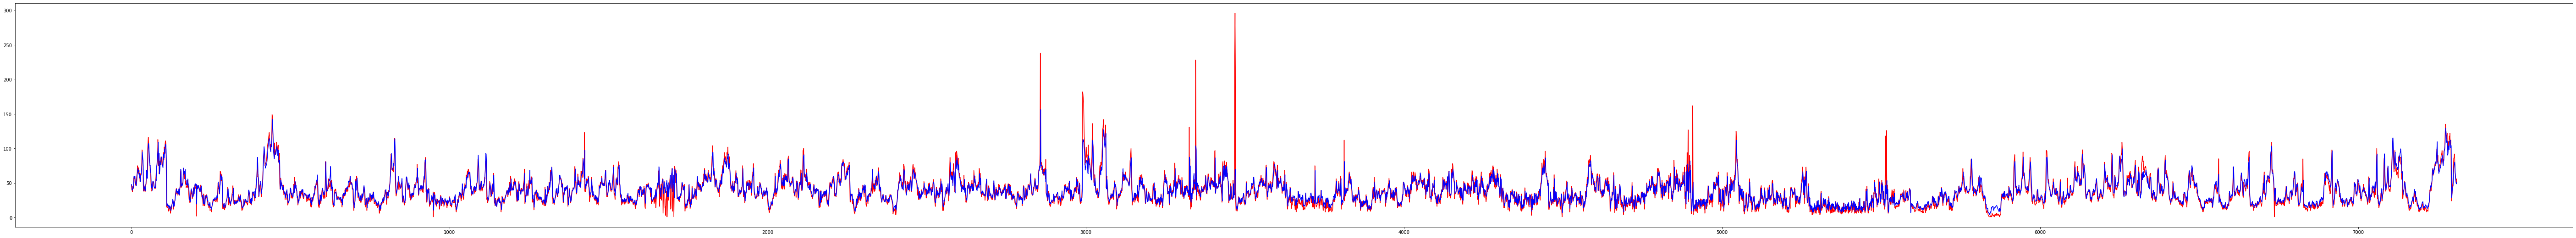

In [242]:
plt.figure(figsize=(100, 9))
plt.plot(y.reset_index().index, y.reset_index()['PM10_res'], color='red')
plt.plot(y.reset_index().index, model.predict(X_minmax)*range_Y.values+min_Y.values, color='blue',)

plt.show()

## 피쳐 추가 후 딥러닝

In [ ]:
shinamdong_drop.head(3)

,측정소명,년,월,일,시,SO2,PM10,PM25,O3,NO2,CO,PM10_res,PM25_res
6,신암동,2017,1,1,1,0.003,50,30,0.002,0.037,0.9,46.0,31.0
17,신암동,2017,1,1,2,0.003,46,31,0.002,0.034,0.8,40.0,29.0
28,신암동,2017,1,1,3,0.002,40,29,0.002,0.031,0.7,40.0,27.0


In [280]:
#단순 선형회귀로 먼저 테스트 해보기
#학습 데이터셋, 결과 데이터셋 만들기
#학습용(현재 PM10), 결과(1시간 후 PM10) 
X = shinamdong_drop[['PM10', 'SO2', 'O3', 'NO2', 'CO']].copy()
y = shinamdong_drop[['PM10_res']].copy()

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [282]:
#minmax 정규화
min_X, max_X = X.min(axis=0), X.max(axis=0)
range_X = max_X - min_X

X_train -= min_X
X_train /= range_X
X_test -= min_X
X_test /= range_X

min_Y, max_Y = y.min(axis=0), y.max(axis=0)
range_Y = max_Y - min_Y
y_train -= min_Y
y_train /= range_Y
y_test -= min_Y
y_test /= range_Y

print(X_train, y_train)

           PM10       SO2        O3       NO2        CO
79085  0.227119  0.157895  0.531532  0.197368  0.285714
43555  0.111864  0.105263  0.486486  0.223684  0.071429
54324  0.138983  0.105263  0.171171  0.105263  0.071429
2305   0.149153  0.105263  0.315315  0.210526  0.214286
42994  0.084746  0.105263  0.306306  0.078947  0.000000
...         ...       ...       ...       ...       ...
33666  0.250847  0.157895  0.558559  0.171053  0.214286
19069  0.091525  0.052632  0.054054  0.421053  0.214286
45150  0.230508  0.157895  0.180180  0.144737  0.071429
24888  0.237288  0.157895  0.054054  0.631579  0.428571
32225  0.074576  0.263158  0.252252  0.157895  0.357143

[5848 rows x 5 columns]        PM10_res
79085  0.155932
43555  0.122034
54324  0.545763
2305   0.138983
42994  0.037288
...         ...
33666  0.223729
19069  0.108475
45150  0.223729
24888  0.250847
32225  0.071186

[5848 rows x 1 columns]


In [301]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(units=20, activation='relu', input_shape=(5,)),
                             tf.keras.layers.Dense(units=16, activation='relu'),
                             tf.keras.layers.Dense(units=12, activation='relu'),
                             tf.keras.layers.Dense(units=8, activation='relu'),
                             tf.keras.layers.Dense(units=1),
])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 20)                120       
_________________________________________________________________
dense_66 (Dense)             (None, 16)                336       
_________________________________________________________________
dense_67 (Dense)             (None, 12)                204       
_________________________________________________________________
dense_68 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 9         
Total params: 773
Trainable params: 773
Non-trainable params: 0
_________________________________________________________________


In [302]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')

In [303]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')])

Epoch 1/100
147/147 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 2/100
147/147 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 3/100
147/147 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 4/100
147/147 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 5/100
147/147 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 6/100
147/147 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 7/100
147/147 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 8/100
147/147 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 9/100
147/147 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 10/100
147/147 [==============================] - 0s 2ms/step - loss: 0.0010 - val_lo

In [304]:
y_pred = model.predict(X_test)
u = ((y_test - y_pred) ** 2).sum()
v = ((y_test - y_test.mean()) ** 2).sum()
R = 1 - (u / v)
R

PM10_res    0.749047
dtype: float64

In [305]:
X_minmax = X.copy()
X_minmax -= min_X
X_minmax /=  range_X

In [306]:
model.predict(X_minmax)

array([[0.18218401],
       [0.16443864],
       [0.13982944],
       ...,
       [0.1679737 ],
       [0.16525148],
       [0.171053  ]], dtype=float32)

In [307]:
model.predict(X_minmax)*range_Y.values+min_Y.values

array([[54.74428317],
       [49.50939736],
       [42.24968536],
       ...,
       [50.55224067],
       [49.74918617],
       [51.46063714]])

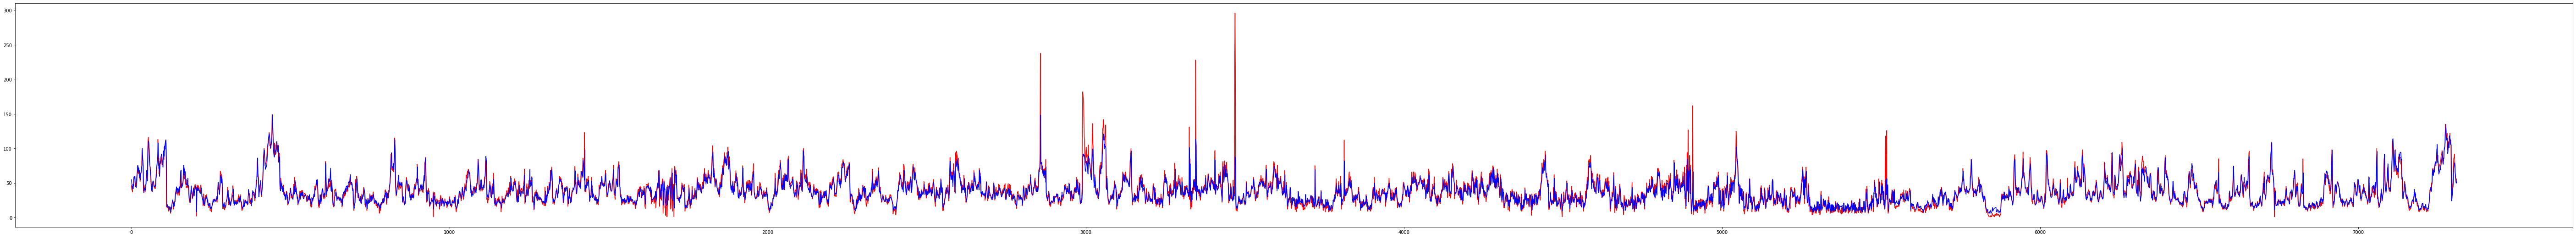

In [308]:
plt.figure(figsize=(100, 9))
plt.plot(y.reset_index().index, y.reset_index()['PM10_res'], color='red')
plt.plot(y.reset_index().index, model.predict(X_minmax)*range_Y.values+min_Y.values, color='blue',)

plt.show()